# Vector Field Example

This notebook demonstrates how to create an entire vector field and parse it into a template for OpenFOAM simulations.

In [1]:
import uqtopus as uqt
uqt.__version__

'0.1.0'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from scipy.interpolate import griddata

from uqtopus import (
    run_simulation, uq_simulation, 
    parse_openfoam_case, read_uq_experiment
)

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

Read the exact field positions to create and plot the velocity field.

In [3]:
from fluidfoam import readmesh  

case_path = 'templates/scalarTransportFoamVelocity'
x, y, z = readmesh(case_path, verbose=False)

For this example we are going to generate a field based on mathematical functions. However, it is possible to use any strategy to create a field and parameterize it into the OpenFOAM template.

In [4]:
U0 = 9.0
H = 0.05
alpha = 2.0

# Velocity field definition
u = lambda x, y: U0 * ((x / H)**2 * np.sin(np.pi * y) + 0.5)
v = lambda x, y: alpha * (-0.5 + np.sin(np.pi * x) * (y / H))

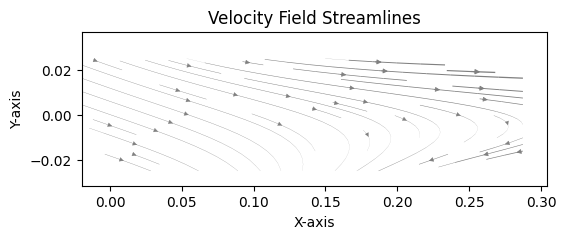

In [5]:
vel = np.array([
    (u(xi, yi), v(xi, yi), 0) for xi, yi in zip(x.flatten(), y.flatten())
])
ux_orig = vel[:, 0]
uy_orig = vel[:, 1]

xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(xi, yi)

uxi = griddata((x, y), ux_orig, (X, Y), method='cubic')
uyi = griddata((x, y), uy_orig, (X, Y), method='cubic')

uxi = np.nan_to_num(uxi)
uyi = np.nan_to_num(uyi)

ut_grid = np.sqrt(uxi**2 + uyi**2)

lw = ut_grid / 20

plt.figure(figsize=(6, 2))
plt.streamplot(xi, yi, uxi, uyi, density=0.6, color='gray', linewidth=lw, arrowsize=0.7)

plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Velocity Field Streamlines")
plt.show()

## 1. Single realization

In [6]:
exp_config = {
    'solver': 'Allrun', # Name of the bash script to run your simulation
    'input_path': "templates/scalarTransportFoamVelocity",   # Base directory with the templated files
    'output_path': "experiments/singleVectorField",      # Path to store the experiments results (Optional, default 'experiments/temp' in your local folder)
    'parameter_ranges': {
        '0__U__velocities': None  # Only key names are necessary for uq_simulation
    },
    'nthreads': 3
}

In [9]:
run_simulation(params={'0__U__velocities': vel }, exp_config=exp_config, verbose=False)

True

In [10]:
# read the OpenFOAM 
data_single = parse_openfoam_case(
    case_dir=exp_config['output_path'],
    variables=["U", "T"],
)
data_single

<xarray.Dataset> Size: 9MB
Dimensions:  (time: 21, cell: 12225, component: 3)
Coordinates:
  * time     (time) float64 168B 0.0 0.005 0.01 0.015 ... 0.085 0.09 0.095 0.1
    x        (cell) float64 98kB -0.01981 -0.01826 -0.01677 ... 0.2824 0.2874
    y        (cell) float64 98kB 0.0001594 0.0001594 ... 0.01731 0.01678
    z        (cell) float64 98kB 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Dimensions without coordinates: cell, component
Data variables:
    U        (time, cell, component) float64 6MB 4.501 -1.0 0.0 ... -0.4729 0.0
    T        (time, cell) float64 2MB 0.0 0.0 0.0 0.0 ... 0.7269 0.7336 0.7378

In [11]:
# To avoid convex hull connections in the field plot
triang = tri.Triangulation(x, y)
mask = []
for t in triang.triangles:
    x_tri = x[t]
    if (x_tri.max() - x_tri.min()) > 0.01:
        mask.append(True)
    else:
        mask.append(False)
triang.set_mask(mask)


xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(xi, yi)

mask_invalid = (X < 0.0) & (Y < 0.0)

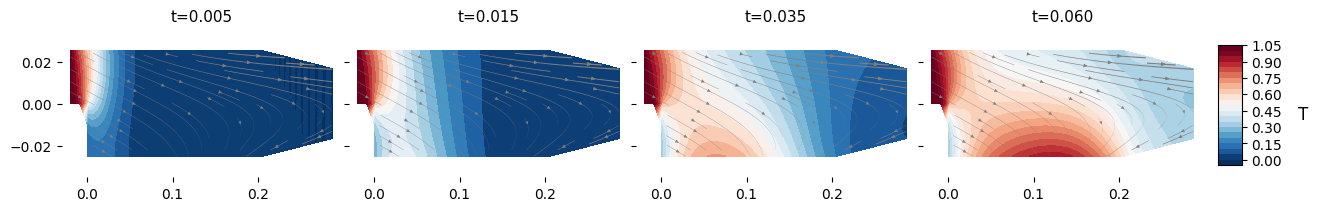

In [12]:
times = [0.005, 0.015, 0.035, 0.06]
time_indices = [data_single.time.get_index('time').get_indexer([t], method='nearest')[0] for t in times]

fig, axs = plt.subplots(1, len(times), figsize=(12, 2), sharex=True, sharey=True, constrained_layout=True)


for i, tidx in enumerate(time_indices):
    temp = data_single['T'].isel(time=tidx).values
    
    x = data_single.x.values
    y = data_single.y.values
    
    cs = axs[i].tricontourf(triang, temp, cmap='RdBu_r', levels=20, vmin=0, vmax=1)
    
    vel = data_single['U'].isel(time=tidx).values
    ux_orig = vel[:, 0]
    uy_orig = vel[:, 1]

    uxi = griddata((x, y), ux_orig, (X, Y), method='cubic')
    uyi = griddata((x, y), uy_orig, (X, Y), method='cubic')

    uxi[mask_invalid] = np.nan
    uyi[mask_invalid] = np.nan
    
    ut_grid = np.sqrt(uxi**2 + uyi**2)

    lw = ut_grid / 20
    axs[i].streamplot(xi, yi, uxi, uyi, density=0.6, color='gray', linewidth=lw, arrowsize=0.5)
    
    for spine in axs[i].spines.values():
        spine.set_visible(False)
    
    axs[i].set_xlim([x.min()-0.01, x.max()+0.01])
    axs[i].set_ylim([y.min()-0.01, y.max()+0.01])
    
    axs[i].set_title(f't={times[i]:.3f}', fontsize=11)

cs = axs[0].collections[0]
cbar_ax = fig.add_axes([1.01, 0.2, 0.02, 0.6])
cbar = fig.colorbar(cs, cax=cbar_ax)
cbar.set_label('T', rotation=0, labelpad=15, fontsize=12)
plt.show()

## 2. Multiple realizations

Here we present a way to set multiple vector fields and execute their simulations using `uqtopus` structure.

In [13]:
exp_config['output_path'] = 'experiments/vectorFields'

In [14]:
X = []

for (U0, alpha) in [[12, 3], [18, -1], [6, 6]]:
    vel = np.array([
        (u(xi, yi), v(xi, yi), 0) for xi, yi in zip(x, y)
    ])
    X.append(vel)
X = np.array(X).reshape(3, 1, 12_225, 3)    # Ensure dim 1 is the number of variables randomized
uq_simulation(X, exp_config)


Running simulations: 100%|██████████| 3/3 [00:51<00:00, 17.26s/it]

UQ study completed. Results saved in 'experiments/vectorFields' folder


In [15]:
ds = read_uq_experiment(
    case_dir=exp_config['output_path'],
    variables=["U", "T"],
    n_samples=3,
    time_dirs=[f"{i:g}" for i in np.arange(0, 0.1 + 1e-6, 0.005)],
    nthreads=3
)
ds

Processing cases: 100%|██████████| 3/3 [00:50<00:00, 16.71s/case]


<xarray.Dataset> Size: 25MB
Dimensions:  (sample: 3, time: 21, cell: 12225, component: 3)
Coordinates:
  * time     (time) float64 168B 0.0 0.005 0.01 0.015 ... 0.085 0.09 0.095 0.1
    x        (cell) float64 98kB -0.01981 -0.01826 -0.01677 ... 0.2824 0.2874
    y        (cell) float64 98kB 0.0001594 0.0001594 ... 0.01731 0.01678
    z        (cell) float64 98kB 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
  * sample   (sample) int64 24B 0 1 2
Dimensions without coordinates: cell, component
Data variables:
    U        (sample, time, cell, component) float64 18MB 6.001 -1.501 ... 0.0
    T        (sample, time, cell) float64 6MB 0.0 0.0 0.0 ... 0.319 0.3185

In [16]:
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(xi, yi)

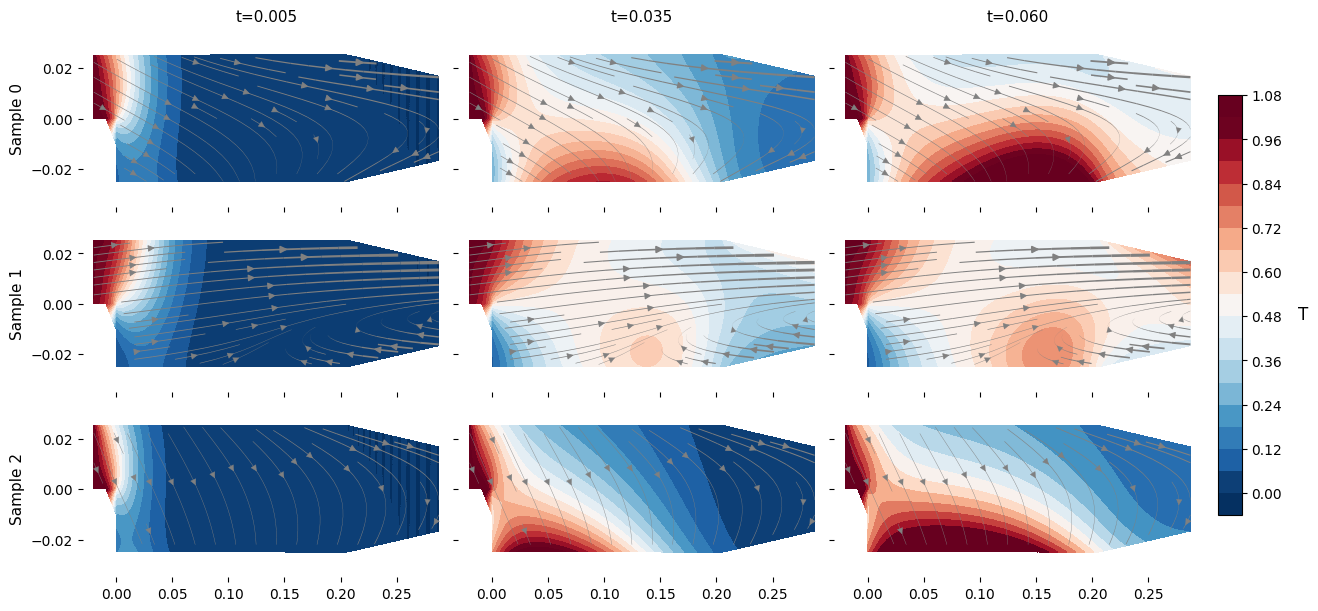

In [17]:
times = [0.005, 0.035, 0.06]
time_indices = [ds.time.get_index('time').get_indexer([t], method='nearest')[0] for t in times]

fig, axs = plt.subplots(3, len(times), figsize=(12, 6), sharex=True, sharey=True, constrained_layout=True)

for row in range(3):
    for col, tidx in enumerate(time_indices):
        ax = axs[row, col]
        
        # Scalar T field
        temp = ds['T'].isel(sample=row, time=tidx).values
        x = ds.x.values
        y = ds.y.values

        cs = ax.tricontourf(triang, temp, cmap='RdBu_r', levels=20, vmin=0, vmax=1)

        # Velocity field
        vel = ds['U'].isel(sample=row, time=tidx).values
        ux_orig = vel[:, 0]
        uy_orig = vel[:, 1]
        
        uxi = griddata((x, y), ux_orig, (X, Y), method='cubic')
        uyi = griddata((x, y), uy_orig, (X, Y), method='cubic')
            
        uxi[mask_invalid] = np.nan
        uyi[mask_invalid] = np.nan
        
        ut_grid = np.sqrt(uxi**2 + uyi**2)
        lw = ut_grid / 15
        
        ax.streamplot(xi, yi, uxi, uyi, density=0.6, color='gray', linewidth=lw)
        
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        ax.set_xlim([x.min()-0.01, x.max()+0.01])
        ax.set_ylim([y.min()-0.01, y.max()+0.01])
        
        # Add time label (only on top row)
        if row == 0:
            ax.set_title(f't={times[col]:.3f}', fontsize=11)
        
        # Add sample label (only on leftmost column)
        if col == 0:
            ax.set_ylabel(f'Sample {row}', fontsize=11)

cs = axs[0,0].collections[0]
cbar_ax = fig.add_axes([1.01, 0.15, 0.02, 0.7])
cbar = fig.colorbar(cs, cax=cbar_ax)
cbar.set_label('T', rotation=0, labelpad=15, fontsize=12)

plt.show()